# **Memory Profiling Analysis**
Using the *memory_profiler* pip package, we analyse ClusTCR's memory usage against iSMART, GLIPH2 and tcrdist3.


In [9]:
import os

# Path to clusTCR repo goes here:
homedir = '/path_to_repo/clusTCR/' 
os.chdir(homedir)

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from memory_profiler import memory_usage

from clustcr.clustering.clustering import Clustering
from clustcr.input.datasets import metarepertoire
from clustcr.modules.gliph2.gliph2 import GLIPH2
from clustcr.modules.ismart.ismart import iSMART
from clustcr.modules.tcrdist.pw_tcrdist import tcrdist

In [3]:
plt.style.use(['seaborn-white', 'seaborn-paper'])
plt.rc('font', family='serif')
sns.set_palette('Set1')
sns.set_context('paper', font_scale=1.3)

Set the path to a folder containing immuneaccess data files (such as Emerson et al)

In [4]:
IMMUNEACCESS = '/path_to_data/'

We define some helper functions to profile the memory usage and retrieve data from the above folder.

In [5]:
def memory(f, *args):
    return memory_usage((f, args, {}), include_children=True,  max_usage=True)


def meta(n, out='CDR3'):
    return metarepertoire(directory=IMMUNEACCESS,
                          data_format='immuneaccess',
                          out_format=out,
                          n_sequences=n)

In [7]:
sample_sizes = [2000, 4000, 8000, 20000, 60000]
result = {
    'GLIPH2': [],
    'iSMART': [],
    'ClusTCR²': [],
    'ClusTCR¹': [],
    'TCRDist*': []
}

for size in sample_sizes:
    cdr3 = meta(size)
    cdr3_gliph2 = meta(size, 'GLIPH2')
    cdr3_tcrdist = meta(size, 'TCRDIST')

    result['TCRDist*'].append(memory(tcrdist, cdr3_tcrdist) if size < 10000 else None)
    result['GLIPH2'].append(memory(GLIPH2, cdr3_gliph2))
    result['iSMART'].append(memory(iSMART, cdr3))
    result['ClusTCR²'].append(memory(lambda: Clustering(n_cpus='all').fit(cdr3)))
    result['ClusTCR¹'].append(memory(lambda: Clustering().fit(cdr3)))

os.chdir(homedir)
pd.DataFrame(result).to_csv('./results/method_comparison_memory.tsv', sep='\t', index=False)

## **Plot results**

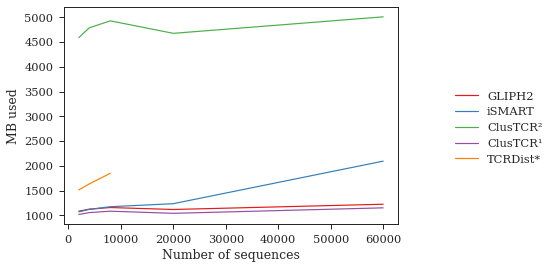

In [46]:
os.chdir(homedir)

fig, ax = plt.subplots()
for name, values in result.items():
    ax.plot(sample_sizes, values, label=name)
ax.set_xlabel('Number of sequences')
ax.set_ylabel('MB used')

ax.legend(loc="lower center",borderaxespad=.1,bbox_to_anchor=(1.30, .25))
fig.savefig('./results/figures/methods_comparison_memory.eps', format='eps', bbox_inches='tight')